In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import folium
from folium import Circle
from geopy import Nominatim

from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

In [2]:
city = pd.read_csv('cost-of-living.csv')
city.head()

,Unnamed: 0,"Saint Petersburg, Russia","Istanbul, Turkey","Izmir, Turkey","Helsinki, Finland","Chisinau, Moldova","Milan, Italy","Cairo, Egypt","Banja Luka, Bosnia And Herzegovina","Baku, Azerbaijan","Guadalajara, Mexico","Kathmandu, Nepal","Hanoi, Vietnam","Ho Chi Minh City, Vietnam","Mexico City, Mexico","Rome, Italy","Monterrey, Mexico","Yekaterinburg, Russia","Sarajevo, Bosnia And Herzegovina","Kharkiv, Ukraine","Kiev, Ukraine","Calgary, Canada","Tunis, Tunisia","Edmonton, Canada","Amsterdam, Netherlands","Belgrade, Serbia","Odessa, Ukraine","Paris, France","Eindhoven, Netherlands","Plovdiv, Bulgaria","Thessaloniki, Greece","Ottawa, Canada","Sofia, Bulgaria","Rotterdam, Netherlands","Varna, Bulgaria","Novi Sad, Serbia","Utrecht, Netherlands","Berlin, Germany","Beirut, Lebanon","Austin, TX, United States",...,"Tel Aviv-Yafo, Israel","Timisoara, Romania","Taipei, Taiwan","Kolkata, India","Skopje, Macedonia","Shanghai, China","Bangkok, Thailand","Mumbai, India","Reykjavik, Iceland","Amman, Jordan","Pune, India","Stockholm, Sweden","Buenos Aires, Argentina","Minsk, Belarus","San Jose, Costa Rica","Casablanca, Morocco","Lodz, Poland","Montreal, Canada","Sao Paulo, Brazil","Gothenburg, Sweden","Dublin, Ireland","Moscow, Russia","Santo Domingo, Dominican Republic","Adelaide, Australia","Zurich, Switzerland","Yerevan, Armenia","Manila, Philippines","Brisbane, Australia","Jakarta, Indonesia","Ankara, Turkey","Lviv, Ukraine","Novosibirsk, Russia","Bursa, Turkey","Brussels, Belgium","Jerusalem, Israel","Melbourne, Australia","Perth, Australia","Sydney, Australia","Alexandria, Egypt","Quito, Ecuador"
0,"Meal, Inexpensive Restaurant",7.34,4.58,3.06,12.00,4.67,15.0,3.38,3.58,5.27,5.25,1.99,1.94,1.94,4.77,15.0,5.75,5.88,3.57,4.50,5.63,13.75,1.92,13.75,15.0,5.39,5.65,15.0,15.0,5.10,10.0,11.00,6.14,13.0,6.12,4.84,15.0,8.5,8.98,13.48,...,15.54,5.23,3.61,2.53,4.87,4.56,1.78,3.80,17.96,6.34,3.16,11.40,5.99,8.93,6.29,4.45,4.72,10.31,6.58,10.45,15.0,8.80,5.10,11.19,23.12,4.70,3.56,12.38,2.62,3.82,3.75,5.72,3.82,15.0,15.56,10.22,12.43,11.81,2.81,3.59
1,"Meal for 2 People, Mid-range Restaurant, Three...",29.35,15.28,12.22,65.00,20.74,60.0,17.48,22.99,23.73,23.86,11.92,15.52,17.50,23.86,55.0,23.94,29.42,20.42,18.76,22.51,42.97,12.78,48.12,65.0,24.62,20.67,50.0,56.5,20.42,35.0,55.00,25.57,50.0,20.42,17.85,65.0,40.0,53.91,44.92,...,64.75,20.91,24.04,10.76,16.25,26.04,23.74,15.19,109.16,38.02,12.66,66.47,20.97,27.95,42.47,20.63,23.61,44.69,28.51,75.97,60.0,36.69,34.01,40.39,92.46,22.54,17.82,49.54,16.40,15.28,18.76,22.01,11.47,60.0,62.24,49.54,56.55,54.37,14.06,31.45
2,McMeal at McDonalds (or Equivalent Combo Meal),4.40,3.82,3.06,8.00,4.15,8.0,4.51,3.58,4.22,4.25,5.56,3.88,3.87,4.77,8.0,4.31,4.12,4.08,3.75,3.75,6.87,3.19,6.53,8.0,5.09,3.67,8.7,8.0,4.59,6.5,6.87,4.60,8.0,4.08,4.42,8.0,7.0,7.19,7.19,...,12.95,4.18,3.91,3.79,3.25,4.56,5.04,3.80,11.64,6.34,3.16,7.60,4.94,4.49,6.29,5.16,4.25,6.87,5.92,7.60,8.0,4.40,5.10,6.84,12.94,4.60,2.67,7.43,3.28,3.51,3.56,3.67,3.06,8.2,12.97,7.12,7.32,7.15,3.38,5.39
3,Domestic Beer (0.5 liter draught),2.20,3.06,2.29,6.50,1.04,5.0,1.69,1.02,0.84,1.43,2.38,0.78,0.78,1.91,5.0,1.68,1.47,1.79,0.88,1.13,4.81,1.60,4.12,5.0,1.70,0.94,7.0,5.0,1.28,3.5,4.81,1.53,4.0,1.02,1.50,5.0,3.5,3.22,4.49,...,7.77,1.25,1.77,1.87,1.62,1.30,2.37,2.28,8.73,6.34,2.28,6.55,1.50,1.80,2.36,2.58,1.77,4.81,1.97,6.31,5.8,2.93,1.70,4.97,6.24,1.13,1.25,4.95,2.62,2.75,1.50,1.10,2.37,4.0,7.26,5.57,5.90,4.97,1.69,1.35
4,Imported Beer (0.33 liter bottle),2.20,3.06,2.75,6.75,1.43,5.0,2.82,1.53,2.11,2.39,3.18,1.55,1.36,2.86,4.0,2.39,2.94,1.79,1.29,1.80,5.50,1.60,4.12,4.0,1.95,1.20,6.0,3.0,1.53,4.5,4.81,1.97,4.0,1.53,1.80,4.5,3.1,4.17,5.39,...,7.77,1.67,2.10,3.48,1.95,2.93,4.45,3.92,7.28,6.34,3.54,6.65,1.95,2.70,3.81,2.81,1.65,5.50,3.29,6.17,5.5,2.57,2.55,5.59,5.55,1.69,2.32,5.57,3.44,3.06,1.50,2.20,3.06,4.0,7.26,5.57,5.59,4.97,2.81,2.70


In [3]:
locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Saint Petersburg, Russia")
print("Latitude = {}, Longitude = {}".format(location.latitude, location.longitude))

Latitude = 59.938732, Longitude = 30.316229


In [4]:
city = city.T
city.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54
Unnamed: 0,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three...",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),Eggs (regular) (12),Local Cheese (1kg),Water (1.5 liter bottle),Bottle of Wine (Mid-Range),Domestic Beer (0.5 liter bottle),Imported Beer (0.33 liter bottle),Cigarettes 20 Pack (Marlboro),One-way Ticket (Local Transport),"Chicken Breasts (Boneless, Skinless), (1kg)",Monthly Pass (Regular Price),Gasoline (1 liter),Volkswagen Golf,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,"Basic (Electricity, Heating, Cooling, Water, G...",1 min. of Prepaid Mobile Tariff Local (No Disc...,"Internet (60 Mbps or More, Unlimited Data, Cab...","Fitness Club, Monthly Fee for 1 Adult",Tennis Court Rent (1 Hour on Weekend),"Cinema, International Release, 1 Seat",1 Pair of Jeans (Levis 501 Or Similar),"1 Summer Dress in a Chain Store (Zara, H&M, ...)",1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Price per Square Meter to Buy Apartment in Cit...,Price per Square Meter to Buy Apartment Outsid...,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yea...",Taxi Start (Normal Tariff),Taxi 1km (Normal Tariff),Taxi 1hour Waiting (Normal Tariff),Apples (1kg),Oranges (1kg),Potato (1kg),Lettuce (1 head),Cappuccino (regular),"Rice (white), (1kg)",Tomato (1kg),Banana (1kg),Onion (1kg),Beef Round (1kg) (or Equivalent Back Leg Red M...,Toyota Corolla 1.6l 97kW Comfort (Or Equivalen...,"Preschool (or Kindergarten), Full Day, Private...","International Primary School, Yearly for 1 Child"
"Saint Petersburg, Russia",7.34,29.35,4.4,2.2,2.2,0.76,0.53,0.98,0.71,1.18,7.6,0.63,5.87,0.88,1.89,2.2,0.59,3.96,42.56,0.67,19289.4,524.45,344.27,1012.53,615.19,102.17,0.03,6.96,26.27,18.33,5.14,71.86,38.25,74.88,100.72,2476.05,1507.7,645.94,10.29,1.47,0.26,4.4,1.29,1.25,0.56,0.86,1.96,0.92,1.91,0.89,0.48,7.18,19305.3,411.83,5388.86
"Istanbul, Turkey",4.58,15.28,3.82,3.06,3.06,0.64,0.24,0.71,0.36,1.62,5.32,0.33,7.64,1.79,2.48,2.75,0.41,3.5,31.32,1.05,24443.2,291.55,177.72,545.5,314.98,59.33,0.11,14.2,25.1,15.66,3.82,36.15,25.91,61.31,50.58,1315.18,657.05,436,19.08,0.76,0.47,3.59,0.85,0.86,0.59,0.61,1.84,1.3,0.8,1.91,0.62,9.73,20874.7,282.94,6905.43
"Izmir, Turkey",3.06,12.22,3.06,2.29,2.75,0.61,0.22,0.65,0.38,1.51,4.97,0.29,6.11,1.63,2.09,2.29,0.46,3.05,22.92,1.04,24443.2,212.22,128.36,353.76,225.34,51.07,0.09,12.89,20.64,11.67,3.06,33.2,22.48,52.74,42.2,856.54,508.14,392.07,22.23,0.61,0.57,3.51,0.77,0.73,0.52,0.57,1.56,1.31,0.7,1.78,0.58,8.61,20898.8,212.18,4948.41
"Helsinki, Finland",12,65,8,6.5,6.75,2.66,1.89,0.96,2.27,2.02,6.87,1.54,12,2.23,2.95,7.7,2.8,9.42,59.7,1.54,22000,986.93,758.13,1819.32,1271.16,82.66,0.07,22.31,34.54,24.72,14,83.41,31.41,82.49,120.97,7444.54,4099.36,2382.56,1.38,6,1,47.04,2.1,1.75,0.91,2.3,3.87,2.13,2.91,1.61,1.25,12.34,24402.8,351.6,1641


In [5]:
city.rename(columns=city.iloc[0], inplace = True)
city.drop(city.index[0], inplace = True)
city.head()

,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),Eggs (regular) (12),Local Cheese (1kg),Water (1.5 liter bottle),Bottle of Wine (Mid-Range),Domestic Beer (0.5 liter bottle),Imported Beer (0.33 liter bottle),Cigarettes 20 Pack (Marlboro),One-way Ticket (Local Transport),"Chicken Breasts (Boneless, Skinless), (1kg)",Monthly Pass (Regular Price),Gasoline (1 liter),Volkswagen Golf,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,"Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment",1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans),"Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)","Fitness Club, Monthly Fee for 1 Adult",Tennis Court Rent (1 Hour on Weekend),"Cinema, International Release, 1 Seat",1 Pair of Jeans (Levis 501 Or Similar),"1 Summer Dress in a Chain Store (Zara, H&M, ...)",1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Taxi Start (Normal Tariff),Taxi 1km (Normal Tariff),Taxi 1hour Waiting (Normal Tariff),Apples (1kg),Oranges (1kg),Potato (1kg),Lettuce (1 head),Cappuccino (regular),"Rice (white), (1kg)",Tomato (1kg),Banana (1kg),Onion (1kg),Beef Round (1kg) (or Equivalent Back Leg Red Meat),Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car),"Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child","International Primary School, Yearly for 1 Child"
"Saint Petersburg, Russia",7.34,29.35,4.4,2.2,2.2,0.76,0.53,0.98,0.71,1.18,7.6,0.63,5.87,0.88,1.89,2.2,0.59,3.96,42.56,0.67,19289.4,524.45,344.27,1012.53,615.19,102.17,0.03,6.96,26.27,18.33,5.14,71.86,38.25,74.88,100.72,2476.05,1507.7,645.94,10.29,1.47,0.26,4.4,1.29,1.25,0.56,0.86,1.96,0.92,1.91,0.89,0.48,7.18,19305.3,411.83,5388.86
"Istanbul, Turkey",4.58,15.28,3.82,3.06,3.06,0.64,0.24,0.71,0.36,1.62,5.32,0.33,7.64,1.79,2.48,2.75,0.41,3.5,31.32,1.05,24443.2,291.55,177.72,545.5,314.98,59.33,0.11,14.2,25.1,15.66,3.82,36.15,25.91,61.31,50.58,1315.18,657.05,436,19.08,0.76,0.47,3.59,0.85,0.86,0.59,0.61,1.84,1.3,0.8,1.91,0.62,9.73,20874.7,282.94,6905.43
"Izmir, Turkey",3.06,12.22,3.06,2.29,2.75,0.61,0.22,0.65,0.38,1.51,4.97,0.29,6.11,1.63,2.09,2.29,0.46,3.05,22.92,1.04,24443.2,212.22,128.36,353.76,225.34,51.07,0.09,12.89,20.64,11.67,3.06,33.2,22.48,52.74,42.2,856.54,508.14,392.07,22.23,0.61,0.57,3.51,0.77,0.73,0.52,0.57,1.56,1.31,0.7,1.78,0.58,8.61,20898.8,212.18,4948.41
"Helsinki, Finland",12,65,8,6.5,6.75,2.66,1.89,0.96,2.27,2.02,6.87,1.54,12,2.23,2.95,7.7,2.8,9.42,59.7,1.54,22000,986.93,758.13,1819.32,1271.16,82.66,0.07,22.31,34.54,24.72,14,83.41,31.41,82.49,120.97,7444.54,4099.36,2382.56,1.38,6,1,47.04,2.1,1.75,0.91,2.3,3.87,2.13,2.91,1.61,1.25,12.34,24402.8,351.6,1641
"Chisinau, Moldova",4.67,20.74,4.15,1.04,1.43,0.64,0.44,0.68,0.33,1.11,5.79,0.59,3.61,0.77,1.38,1.56,0.1,3.55,9.33,0.98,16335.1,244.49,177.96,428.67,330.84,113.46,0.07,8.58,26.64,12.1,5.19,56.54,35.37,86.25,94.38,904.82,589.13,286.95,9.42,1.3,0.18,3.11,0.7,1.22,0.56,0.84,1.25,0.93,1.56,1.37,0.59,5.37,17238.1,210.52,2679.3


In [6]:
city = city.reset_index()
city = city.rename(columns={'index': 'Location'})
city.head()

,Location,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),Eggs (regular) (12),Local Cheese (1kg),Water (1.5 liter bottle),Bottle of Wine (Mid-Range),Domestic Beer (0.5 liter bottle),Imported Beer (0.33 liter bottle),Cigarettes 20 Pack (Marlboro),One-way Ticket (Local Transport),"Chicken Breasts (Boneless, Skinless), (1kg)",Monthly Pass (Regular Price),Gasoline (1 liter),Volkswagen Golf,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,"Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment",1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans),"Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)","Fitness Club, Monthly Fee for 1 Adult",Tennis Court Rent (1 Hour on Weekend),"Cinema, International Release, 1 Seat",1 Pair of Jeans (Levis 501 Or Similar),"1 Summer Dress in a Chain Store (Zara, H&M, ...)",1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Taxi Start (Normal Tariff),Taxi 1km (Normal Tariff),Taxi 1hour Waiting (Normal Tariff),Apples (1kg),Oranges (1kg),Potato (1kg),Lettuce (1 head),Cappuccino (regular),"Rice (white), (1kg)",Tomato (1kg),Banana (1kg),Onion (1kg),Beef Round (1kg) (or Equivalent Back Leg Red Meat),Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car),"Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child","International Primary School, Yearly for 1 Child"
0,"Saint Petersburg, Russia",7.34,29.35,4.4,2.2,2.2,0.76,0.53,0.98,0.71,1.18,7.6,0.63,5.87,0.88,1.89,2.2,0.59,3.96,42.56,0.67,19289.4,524.45,344.27,1012.53,615.19,102.17,0.03,6.96,26.27,18.33,5.14,71.86,38.25,74.88,100.72,2476.05,1507.7,645.94,10.29,1.47,0.26,4.4,1.29,1.25,0.56,0.86,1.96,0.92,1.91,0.89,0.48,7.18,19305.3,411.83,5388.86
1,"Istanbul, Turkey",4.58,15.28,3.82,3.06,3.06,0.64,0.24,0.71,0.36,1.62,5.32,0.33,7.64,1.79,2.48,2.75,0.41,3.5,31.32,1.05,24443.2,291.55,177.72,545.5,314.98,59.33,0.11,14.2,25.1,15.66,3.82,36.15,25.91,61.31,50.58,1315.18,657.05,436,19.08,0.76,0.47,3.59,0.85,0.86,0.59,0.61,1.84,1.3,0.8,1.91,0.62,9.73,20874.7,282.94,6905.43
2,"Izmir, Turkey",3.06,12.22,3.06,2.29,2.75,0.61,0.22,0.65,0.38,1.51,4.97,0.29,6.11,1.63,2.09,2.29,0.46,3.05,22.92,1.04,24443.2,212.22,128.36,353.76,225.34,51.07,0.09,12.89,20.64,11.67,3.06,33.2,22.48,52.74,42.2,856.54,508.14,392.07,22.23,0.61,0.57,3.51,0.77,0.73,0.52,0.57,1.56,1.31,0.7,1.78,0.58,8.61,20898.8,212.18,4948.41
3,"Helsinki, Finland",12,65,8,6.5,6.75,2.66,1.89,0.96,2.27,2.02,6.87,1.54,12,2.23,2.95,7.7,2.8,9.42,59.7,1.54,22000,986.93,758.13,1819.32,1271.16,82.66,0.07,22.31,34.54,24.72,14,83.41,31.41,82.49,120.97,7444.54,4099.36,2382.56,1.38,6,1,47.04,2.1,1.75,0.91,2.3,3.87,2.13,2.91,1.61,1.25,12.34,24402.8,351.6,1641
4,"Chisinau, Moldova",4.67,20.74,4.15,1.04,1.43,0.64,0.44,0.68,0.33,1.11,5.79,0.59,3.61,0.77,1.38,1.56,0.1,3.55,9.33,0.98,16335.1,244.49,177.96,428.67,330.84,113.46,0.07,8.58,26.64,12.1,5.19,56.54,35.37,86.25,94.38,904.82,589.13,286.95,9.42,1.3,0.18,3.11,0.7,1.22,0.56,0.84,1.25,0.93,1.56,1.37,0.59,5.37,17238.1,210.52,2679.3


In [7]:
import warnings
warnings.filterwarnings('ignore')

from geopy.extra.rate_limiter import RateLimiter

geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

city['location'] = city['Location'].apply(geocode)

city['point'] = city['location'].apply(lambda loc: tuple(loc.point) if loc else None)

city[['latitude', 'longitude', 'altitude']] = pd.DataFrame(city['point'].tolist(), index=city.index)

city.head()

,Location,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),Eggs (regular) (12),Local Cheese (1kg),Water (1.5 liter bottle),Bottle of Wine (Mid-Range),Domestic Beer (0.5 liter bottle),Imported Beer (0.33 liter bottle),Cigarettes 20 Pack (Marlboro),One-way Ticket (Local Transport),"Chicken Breasts (Boneless, Skinless), (1kg)",Monthly Pass (Regular Price),Gasoline (1 liter),Volkswagen Golf,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,"Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment",1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans),"Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)","Fitness Club, Monthly Fee for 1 Adult",Tennis Court Rent (1 Hour on Weekend),"Cinema, International Release, 1 Seat",1 Pair of Jeans (Levis 501 Or Similar),"1 Summer Dress in a Chain Store (Zara, H&M, ...)",1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Taxi Start (Normal Tariff),Taxi 1km (Normal Tariff),Taxi 1hour Waiting (Normal Tariff),Apples (1kg),Oranges (1kg),Potato (1kg),Lettuce (1 head),Cappuccino (regular),"Rice (white), (1kg)",Tomato (1kg),Banana (1kg),Onion (1kg),Beef Round (1kg) (or Equivalent Back Leg Red Meat),Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car),"Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child","International Primary School, Yearly for 1 Child",location,point,latitude,longitude,altitude
0,"Saint Petersburg, Russia",7.34,29.35,4.4,2.2,2.2,0.76,0.53,0.98,0.71,1.18,7.6,0.63,5.87,0.88,1.89,2.2,0.59,3.96,42.56,0.67,19289.4,524.45,344.27,1012.53,615.19,102.17,0.03,6.96,26.27,18.33,5.14,71.86,38.25,74.88,100.72,2476.05,1507.7,645.94,10.29,1.47,0.26,4.4,1.29,1.25,0.56,0.86,1.96,0.92,1.91,0.89,0.48,7.18,19305.3,411.83,5388.86,"(Санкт-Петербург, Северо-Западный федеральный ...","(59.938732, 30.316229, 0.0)",59.938732,30.316229,0.0
1,"Istanbul, Turkey",4.58,15.28,3.82,3.06,3.06,0.64,0.24,0.71,0.36,1.62,5.32,0.33,7.64,1.79,2.48,2.75,0.41,3.5,31.32,1.05,24443.2,291.55,177.72,545.5,314.98,59.33,0.11,14.2,25.1,15.66,3.82,36.15,25.91,61.31,50.58,1315.18,657.05,436,19.08,0.76,0.47,3.59,0.85,0.86,0.59,0.61,1.84,1.3,0.8,1.91,0.62,9.73,20874.7,282.94,6905.43,"(İstanbul, Fatih, İstanbul, Marmara Bölgesi, 3...","(41.0096334, 28.9651646, 0.0)",41.009633,28.965165,0.0
2,"Izmir, Turkey",3.06,12.22,3.06,2.29,2.75,0.61,0.22,0.65,0.38,1.51,4.97,0.29,6.11,1.63,2.09,2.29,0.46,3.05,22.92,1.04,24443.2,212.22,128.36,353.76,225.34,51.07,0.09,12.89,20.64,11.67,3.06,33.2,22.48,52.74,42.2,856.54,508.14,392.07,22.23,0.61,0.57,3.51,0.77,0.73,0.52,0.57,1.56,1.31,0.7,1.78,0.58,8.61,20898.8,212.18,4948.41,"(İzmir, Konak, İzmir, Ege Bölgesi, UNKNWON, Tü...","(38.4147331, 27.1434119, 0.0)",38.414733,27.143412,0.0
3,"Helsinki, Finland",12,65,8,6.5,6.75,2.66,1.89,0.96,2.27,2.02,6.87,1.54,12,2.23,2.95,7.7,2.8,9.42,59.7,1.54,22000,986.93,758.13,1819.32,1271.16,82.66,0.07,22.31,34.54,24.72,14,83.41,31.41,82.49,120.97,7444.54,4099.36,2382.56,1.38,6,1,47.04,2.1,1.75,0.91,2.3,3.87,2.13,2.91,1.61,1.25,12.34,24402.8,351.6,1641,"(Helsinki, Helsingin seutukunta, Uusimaa, Etel...","(60.1674881, 24.9427473, 0.0)",60.167488,24.942747,0.0
4,"Chisinau, Moldova",4.67,20.74,4.15,1.04,1.43,0.64,0.44,0.68,0.33,1.11,5.79,0.59,3.61,0.77,1.38,1.56,0.1,3.55,9.33,0.98,16335.1,244.49,177.96,428.67,330.84,113.46,0.07,8.58,26.64,12.1,5.19,56.54,35.37,86.25,94.38,904.82,589.13,286.95,9.42,1.3,0.18,

In [8]:
city = city.drop(['location','point','altitude'], axis = 1)
city.columns

Index(['Location', 'Meal, Inexpensive Restaurant',
       'Meal for 2 People, Mid-range Restaurant, Three-course',
       'McMeal at McDonalds (or Equivalent Combo Meal)',
       'Domestic Beer (0.5 liter draught)',
       'Imported Beer (0.33 liter bottle)', 'Coke/Pepsi (0.33 liter bottle)',
       'Water (0.33 liter bottle) ', 'Milk (regular), (1 liter)',
       'Loaf of Fresh White Bread (500g)', 'Eggs (regular) (12)',
       'Local Cheese (1kg)', 'Water (1.5 liter bottle)',
       'Bottle of Wine (Mid-Range)', 'Domestic Beer (0.5 liter bottle)',
       'Imported Beer (0.33 liter bottle)', 'Cigarettes 20 Pack (Marlboro)',
       'One-way Ticket (Local Transport)',
       'Chicken Breasts (Boneless, Skinless), (1kg)',
       'Monthly Pass (Regular Price)', 'Gasoline (1 liter)', 'Volkswagen Golf',
       'Apartment (1 bedroom) in City Centre',
       'Apartment (1 bedroom) Outside of Centre',
       'Apartment (3 bedrooms) in City Centre',
       'Apartment (3 bedrooms) Outside of Cen

##Aggregating features

In [9]:
def food(city):
    return int(round((city[['Meal, Inexpensive Restaurant',
       'Domestic Beer (0.5 liter draught)',
       'Imported Beer (0.33 liter bottle)', 'Coke/Pepsi (0.33 liter bottle)',
       'Water (0.33 liter bottle) ', 'Milk (regular), (1 liter)',
       'Loaf of Fresh White Bread (500g)', 'Eggs (regular) (12)',
       'Local Cheese (1kg)', 'Water (1.5 liter bottle)',
       'Bottle of Wine (Mid-Range)', 'Domestic Beer (0.5 liter bottle)',
       'Imported Beer (0.33 liter bottle)', 'Cigarettes 20 Pack (Marlboro)',
       'Chicken Breasts (Boneless, Skinless), (1kg)', 'Apples (1kg)', 'Oranges (1kg)',
       'Potato (1kg)', 'Lettuce (1 head)', 'Cappuccino (regular)',
       'Rice (white), (1kg)', 'Tomato (1kg)', 'Banana (1kg)', 'Onion (1kg)',
       'Beef Round (1kg) (or Equivalent Back Leg Red Meat)',]].mean()).mean()))

def travel(city):
    return int(round((city[['One-way Ticket (Local Transport)',
                            'Monthly Pass (Regular Price)', 'Gasoline (1 liter)',
                           'Taxi Start (Normal Tariff)', 'Taxi 1km (Normal Tariff)',
                           'Taxi 1hour Waiting (Normal Tariff)',]].mean()).mean()))

def living(city):
    return int(round((city[[ 'Volkswagen Golf',
       'Apartment (1 bedroom) in City Centre',
       'Apartment (1 bedroom) Outside of Centre',
       'Apartment (3 bedrooms) in City Centre',
       'Apartment (3 bedrooms) Outside of Centre',
       'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment',
         'Price per Square Meter to Buy Apartment in City Centre',
       'Price per Square Meter to Buy Apartment Outside of Centre',
        'Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car)',]].mean()).mean()))

def lifestyle(city):
    return int(round((city[['1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans)',
       'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)',
       'Fitness Club, Monthly Fee for 1 Adult',
       'Tennis Court Rent (1 Hour on Weekend)',
       'Cinema, International Release, 1 Seat',
       '1 Pair of Jeans (Levis 501 Or Similar)',
       '1 Summer Dress in a Chain Store (Zara, H&M, ...)',
       '1 Pair of Nike Running Shoes (Mid-Range)',
       '1 Pair of Men Leather Business Shoes', 
       'Meal for 2 People, Mid-range Restaurant, Three-course',
       'McMeal at McDonalds (or Equivalent Combo Meal)',]].mean()).mean()))

def education(city):
    return int(round((city[['Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child',
       'International Primary School, Yearly for 1 Child',]].mean()).mean()))

def income(city):
    return int(round((city[['Average Monthly Net Salary (After Tax)',
       'Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate',]].mean()).mean()))

In [10]:
city['Food'] = city.apply(food, axis = 1)
city['Travel'] = city.apply(travel, axis = 1)
city['Living'] = city.apply(living, axis = 1)
city['Lifestyle'] = city.apply(lifestyle, axis = 1)
city['Education'] = city.apply(education, axis = 1)
city.head()

,Location,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),Eggs (regular) (12),Local Cheese (1kg),Water (1.5 liter bottle),Bottle of Wine (Mid-Range),Domestic Beer (0.5 liter bottle),Imported Beer (0.33 liter bottle),Cigarettes 20 Pack (Marlboro),One-way Ticket (Local Transport),"Chicken Breasts (Boneless, Skinless), (1kg)",Monthly Pass (Regular Price),Gasoline (1 liter),Volkswagen Golf,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,"Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment",1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans),"Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)","Fitness Club, Monthly Fee for 1 Adult",Tennis Court Rent (1 Hour on Weekend),"Cinema, International Release, 1 Seat",1 Pair of Jeans (Levis 501 Or Similar),"1 Summer Dress in a Chain Store (Zara, H&M, ...)",1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Taxi Start (Normal Tariff),Taxi 1km (Normal Tariff),Taxi 1hour Waiting (Normal Tariff),Apples (1kg),Oranges (1kg),Potato (1kg),Lettuce (1 head),Cappuccino (regular),"Rice (white), (1kg)",Tomato (1kg),Banana (1kg),Onion (1kg),Beef Round (1kg) (or Equivalent Back Leg Red Meat),Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car),"Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child","International Primary School, Yearly for 1 Child",latitude,longitude,Food,Travel,Living,Lifestyle,Education
0,"Saint Petersburg, Russia",7.34,29.35,4.4,2.2,2.2,0.76,0.53,0.98,0.71,1.18,7.6,0.63,5.87,0.88,1.89,2.2,0.59,3.96,42.56,0.67,19289.4,524.45,344.27,1012.53,615.19,102.17,0.03,6.96,26.27,18.33,5.14,71.86,38.25,74.88,100.72,2476.05,1507.7,645.94,10.29,1.47,0.26,4.4,1.29,1.25,0.56,0.86,1.96,0.92,1.91,0.89,0.48,7.18,19305.3,411.83,5388.86,59.938732,30.316229,2,8,5020,34,2900
1,"Istanbul, Turkey",4.58,15.28,3.82,3.06,3.06,0.64,0.24,0.71,0.36,1.62,5.32,0.33,7.64,1.79,2.48,2.75,0.41,3.5,31.32,1.05,24443.2,291.55,177.72,545.5,314.98,59.33,0.11,14.2,25.1,15.66,3.82,36.15,25.91,61.31,50.58,1315.18,657.05,436,19.08,0.76,0.47,3.59,0.85,0.86,0.59,0.61,1.84,1.3,0.8,1.91,0.62,9.73,20874.7,282.94,6905.43,41.009633,28.965165,2,6,5409,23,3594
2,"Izmir, Turkey",3.06,12.22,3.06,2.29,2.75,0.61,0.22,0.65,0.38,1.51,4.97,0.29,6.11,1.63,2.09,2.29,0.46,3.05,22.92,1.04,24443.2,212.22,128.36,353.76,225.34,51.07,0.09,12.89,20.64,11.67,3.06,33.2,22.48,52.74,42.2,856.54,508.14,392.07,22.23,0.61,0.57,3.51,0.77,0.73,0.52,0.57,1.56,1.31,0.7,1.78,0.58,8.61,20898.8,212.18,4948.41,38.414733,27.143412,2,5,5297,19,2580
3,"Helsinki, Finland",12,65,8,6.5,6.75,2.66,1.89,0.96,2.27,2.02,6.87,1.54,12,2.23,2.95,7.7,2.8,9.42,59.7,1.54,22000,986.93,758.13,1819.32,1271.16,82.66,0.07,22.31,34.54,24.72,14,83.41,31.41,82.49,120.97,7444.54,4099.36,2382.56,1.38,6,1,47.04,2.1,1.75,0.91,2.3,3.87,2.13,2.91,1.61,1.25,12.34,24402.8,351.6,1641,60.167488,24.942747,4,20,6985,44,996
4,"Chisinau, Moldova",4.67,20.74,4.15,1.04,1.43,0.64,0.44,0.68,0.33,1.11,5.79,0.59,3.61,0.77,1.38,1.56,0.1,3.55,9.33,0.98,16335.1,244.49,177.96,428.67,330.84,113.46,0.07,8.58,26.64,12.1,5.19,56.54,35.37,86.25,94.38,904.82,589.13,286.95,9.42,1.3,0.18,3.11,0.7,1.22,0.56,0.84,1.25,0.93,1.56,1.37,0.59,5.37,17238.1,210.52,2679.3,47.024512,28.832292,2,2,4040,32,1445


In [11]:
city['Location'].str.split(', ')[0]

['Saint Petersburg', 'Russia']

In [12]:
city['country'] = city['Location'].str.split(', ')
city['Country'] = city['country'].apply(lambda x:x[1])
city['Country'].value_counts()

India         11
Canada         8
Poland         6
Australia      5
Romania        5
              ..
WA             1
Montenegro     1
OR             1
Estonia        1
Panama         1
Name: Country, Length: 90, dtype: int64

In [14]:
city['Income'] = city.apply(income, axis = 1)
city.head()

,Location,"Meal, Inexpensive Restaurant","Meal for 2 People, Mid-range Restaurant, Three-course",McMeal at McDonalds (or Equivalent Combo Meal),Domestic Beer (0.5 liter draught),Imported Beer (0.33 liter bottle),Coke/Pepsi (0.33 liter bottle),Water (0.33 liter bottle),"Milk (regular), (1 liter)",Loaf of Fresh White Bread (500g),Eggs (regular) (12),Local Cheese (1kg),Water (1.5 liter bottle),Bottle of Wine (Mid-Range),Domestic Beer (0.5 liter bottle),Imported Beer (0.33 liter bottle),Cigarettes 20 Pack (Marlboro),One-way Ticket (Local Transport),"Chicken Breasts (Boneless, Skinless), (1kg)",Monthly Pass (Regular Price),Gasoline (1 liter),Volkswagen Golf,Apartment (1 bedroom) in City Centre,Apartment (1 bedroom) Outside of Centre,Apartment (3 bedrooms) in City Centre,Apartment (3 bedrooms) Outside of Centre,"Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment",1 min. of Prepaid Mobile Tariff Local (No Discounts or Plans),"Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)","Fitness Club, Monthly Fee for 1 Adult",Tennis Court Rent (1 Hour on Weekend),"Cinema, International Release, 1 Seat",1 Pair of Jeans (Levis 501 Or Similar),"1 Summer Dress in a Chain Store (Zara, H&M, ...)",1 Pair of Nike Running Shoes (Mid-Range),1 Pair of Men Leather Business Shoes,Price per Square Meter to Buy Apartment in City Centre,Price per Square Meter to Buy Apartment Outside of Centre,Average Monthly Net Salary (After Tax),"Mortgage Interest Rate in Percentages (%), Yearly, for 20 Years Fixed-Rate",Taxi Start (Normal Tariff),Taxi 1km (Normal Tariff),Taxi 1hour Waiting (Normal Tariff),Apples (1kg),Oranges (1kg),Potato (1kg),Lettuce (1 head),Cappuccino (regular),"Rice (white), (1kg)",Tomato (1kg),Banana (1kg),Onion (1kg),Beef Round (1kg) (or Equivalent Back Leg Red Meat),Toyota Corolla 1.6l 97kW Comfort (Or Equivalent New Car),"Preschool (or Kindergarten), Full Day, Private, Monthly for 1 Child","International Primary School, Yearly for 1 Child",latitude,longitude,Food,Travel,Living,Lifestyle,Education,country,Country,Income
0,"Saint Petersburg, Russia",7.34,29.35,4.4,2.2,2.2,0.76,0.53,0.98,0.71,1.18,7.6,0.63,5.87,0.88,1.89,2.2,0.59,3.96,42.56,0.67,19289.4,524.45,344.27,1012.53,615.19,102.17,0.03,6.96,26.27,18.33,5.14,71.86,38.25,74.88,100.72,2476.05,1507.7,645.94,10.29,1.47,0.26,4.4,1.29,1.25,0.56,0.86,1.96,0.92,1.91,0.89,0.48,7.18,19305.3,411.83,5388.86,59.938732,30.316229,2,8,5020,34,2900,"[Saint Petersburg, Russia]",Russia,328
1,"Istanbul, Turkey",4.58,15.28,3.82,3.06,3.06,0.64,0.24,0.71,0.36,1.62,5.32,0.33,7.64,1.79,2.48,2.75,0.41,3.5,31.32,1.05,24443.2,291.55,177.72,545.5,314.98,59.33,0.11,14.2,25.1,15.66,3.82,36.15,25.91,61.31,50.58,1315.18,657.05,436,19.08,0.76,0.47,3.59,0.85,0.86,0.59,0.61,1.84,1.3,0.8,1.91,0.62,9.73,20874.7,282.94,6905.43,41.009633,28.965165,2,6,5409,23,3594,"[Istanbul, Turkey]",Turkey,228
2,"Izmir, Turkey",3.06,12.22,3.06,2.29,2.75,0.61,0.22,0.65,0.38,1.51,4.97,0.29,6.11,1.63,2.09,2.29,0.46,3.05,22.92,1.04,24443.2,212.22,128.36,353.76,225.34,51.07,0.09,12.89,20.64,11.67,3.06,33.2,22.48,52.74,42.2,856.54,508.14,392.07,22.23,0.61,0.57,3.51,0.77,0.73,0.52,0.57,1.56,1.31,0.7,1.78,0.58,8.61,20898.8,212.18,4948.41,38.414733,27.143412,2,5,5297,19,2580,"[Izmir, Turkey]",Turkey,207
3,"Helsinki, Finland",12,65,8,6.5,6.75,2.66,1.89,0.96,2.27,2.02,6.87,1.54,12,2.23,2.95,7.7,2.8,9.42,59.7,1.54,22000,986.93,758.13,1819.32,1271.16,82.66,0.07,22.31,34.54,24.72,14,83.41,31.41,82.49,120.97,7444.54,4099.36,2382.56,1.38,6,1,47.04,2.1,1.75,0.91,2.3,3.87,2.13,2.91,1.61,1.25,12.34,24402.8,351.6,1641,60.167488,24.942747,4,20,6985,44,996,"[Helsinki, Finland]",Finland,1192
4,"Chisinau, Moldova",4.67,20.74,4.15,1.04,1.43,0.64,0.44,0.68,0.33,1.11,5.79,0.59,3.61,0.77,1.38,1.56,0.1,3.55,9.33,0.98,16335.1,244.49,177.96,428.67,330.84,113.46,0.07,8.58,26.64,12.1,5.19,56.54,35.37,86.25,94.38,904.82,589.13,286.95,9.42,1.3,0.18,3.11,0.7,1.22,0.56,0.84,1.25,0.93,1.56,1.37,0.59,5.37,17238.1,210.52,2679.3,47.024512,28.832292,2,2,4040,32,

In [15]:

city[['Country','Food','Travel','Living','Lifestyle','Education','Income']].groupby(['Country']).agg('mean').style.background_gradient(cmap='Wistia')

,Food,Travel,Living,Lifestyle,Education,Income
Country,,,,,,
AZ,4.000000,16.000000,5114.000000,35.000000,7088.000000,1559.000000
Albania,2.000000,5.000000,4157.000000,29.000000,1225.000000,171.000000
Argentina,2.000000,3.000000,4346.000000,28.000000,1638.000000,266.000000
Armenia,2.000000,3.000000,4390.000000,30.000000,1581.000000,154.000000
Australia,4.400000,21.600000,4932.200000,38.600000,5919.400000,1400.800000
Austria,4.000000,14.000000,6662.000000,40.000000,8124.000000,951.000000
Azerbaijan,2.000000,2.000000,4164.000000,32.000000,2933.000000,151.000000
Belarus,2.000000,3.000000,3932.000000,33.000000,2874.000000,224.000000
Belgium,4.000000,15.000000,5773.000000,42.000000,9519.000000,1146.000000


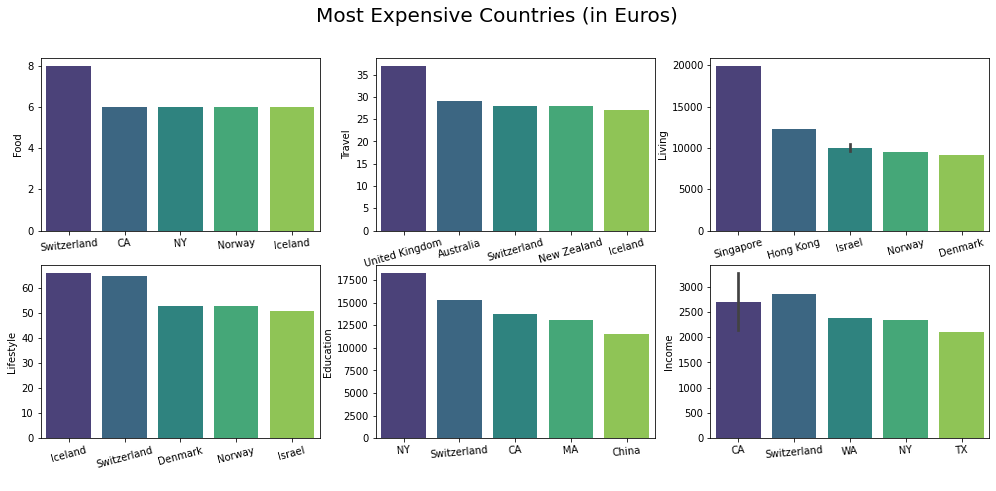

In [19]:
plt.rcParams['figure.figsize'] = (17,7)

plt.subplot(2,3,1)
x = city[['Country','Food']].sort_values(by = 'Food', ascending = False).head(5)
sns.barplot(x['Country'],x['Food'], palette = 'viridis')
plt.xticks(rotation = 5)
plt.xlabel(' ')

plt.subplot(2,3,2)
x = city[['Country','Travel']].sort_values(by = 'Travel', ascending = False).head(5)
sns.barplot(x['Country'],x['Travel'], palette = 'viridis')
plt.xticks(rotation = 16)
plt.xlabel(' ')

plt.subplot(2,3,3)
x = city[['Country','Living']].sort_values(by = 'Living', ascending = False).head(6)
sns.barplot(x['Country'],x['Living'], palette = 'viridis')
plt.xticks(rotation = 15)
plt.xlabel(' ')

plt.subplot(2,3,4)
x = city[['Country','Lifestyle']].sort_values(by = 'Lifestyle', ascending = False).head(5)
sns.barplot(x['Country'],x['Lifestyle'], palette = 'viridis')
plt.xticks(rotation = 15)
plt.xlabel(' ')

plt.subplot(2,3,5)
x = city[['Country','Education']].sort_values(by = 'Education', ascending = False).head(5)
sns.barplot(x['Country'],x['Education'], palette = 'viridis')
plt.xticks(rotation = 5)
plt.xlabel(' ')

plt.subplot(2,3,6)
x = city[['Country','Income']].sort_values(by = 'Income', ascending = False).head(6)
sns.barplot(x['Country'],x['Income'], palette = 'viridis')
plt.xticks(rotation = 5)
plt.xlabel(' ')

plt.suptitle('Most Expensive Countries (in Euros) ', fontsize = 20)
plt.show()


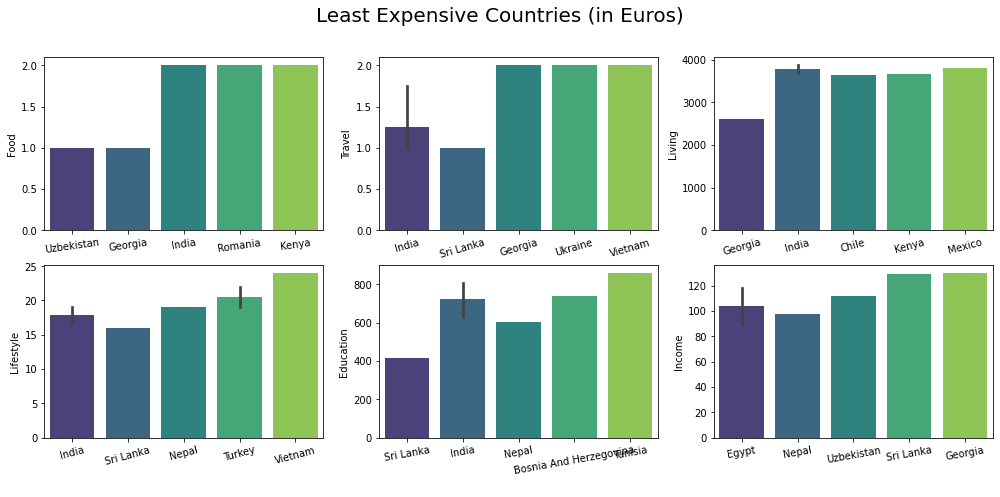

In [21]:
plt.rcParams['figure.figsize'] = (17,7)

plt.subplot(2,3,1)
x = city[['Country','Food']].sort_values(by = 'Food', ascending = True).head(5)
sns.barplot(x['Country'],x['Food'], palette = 'viridis')
plt.xticks(rotation = 8)
plt.xlabel(' ')

plt.subplot(2,3,2)
x = city[['Country','Travel']].sort_values(by = 'Travel', ascending = True).head(9)
sns.barplot(x['Country'],x['Travel'], palette = 'viridis')
plt.xticks(rotation = 16)
plt.xlabel(' ')

plt.subplot(2,3,3)
x = city[['Country','Living']].sort_values(by = 'Living', ascending = True).head(9)
sns.barplot(x['Country'],x['Living'], palette = 'viridis')
plt.xticks(rotation = 15)
plt.xlabel(' ')

plt.subplot(2,3,4)
x = city[['Country','Lifestyle']].sort_values(by = 'Lifestyle', ascending = True).head(18)
sns.barplot(x['Country'],x['Lifestyle'], palette = 'viridis')
plt.xticks(rotation = 15)
plt.xlabel(' ')

plt.subplot(2,3,5)
x = city[['Country','Education']].sort_values(by = 'Education', ascending = True).head(9)
sns.barplot(x['Country'],x['Education'], palette = 'viridis')
plt.xticks(rotation = 10)
plt.xlabel(' ')

plt.subplot(2,3,6)
x = city[['Country','Income']].sort_values(by = 'Income', ascending = True).head(6)
sns.barplot(x['Country'],x['Income'], palette = 'viridis')
plt.xticks(rotation = 10)
plt.xlabel(' ')

plt.suptitle('Least Expensive Countries (in Euros) ', fontsize = 20)
plt.show()

In [23]:
 top_range = (city.describe().loc['min',:]/city.describe().loc['max',:]).sort_values().index[2:22]
 list(top_range)

['Education', 'Travel', 'Income', 'Food', 'Living', 'Lifestyle']

In [24]:
def color_creator(val):
  if val <= city[item].quantile(.25):
    return 'forestgreen'
  elif val <=city[item].quantile(.50):
    return 'goldenrod'
  elif val <=city[item].quantile(.75):
    return 'darked'
  else:
    return 'red' 

In [29]:
map = folium.Map(location = [city['latitude'].mean(),
                             city['longitude'].mean()],
                         tiles = 'Stamen Terrain',
                         zoom_start = 2)
item = top_range[0]

for i in range(0,len(city)):
  Circle( location =[ city.iloc[i]['latitude'],
         city.iloc[i]['longitude']],
         radius = 120000, 
         color = color_creator(city.iloc[i][item])).add_to(map)

print('Price of : ',item)
map

Price of :  Education


In [31]:
map = folium.Map(location=[city['latitude'].mean(),
                           city['longitude'].mean()],
                 tiles='CartoDB dark_matter',
                 zoom_start=2)

item = top_range[1]

# Add a bubble map to the base map
for i in range(0,len(city)):
    Circle(
        location=[city.iloc[i]['latitude'], city.iloc[i]['longitude']],
        radius=120000,
        color=color_creator(city.iloc[i][item])).add_to(map)

print ('Price of: ', item)
map

Price of:  Travel


In [32]:
map = folium.Map(location=[city['latitude'].mean(),
                           city['longitude'].mean()],
                 tiles='Stamen Toner',
                 zoom_start=2)

item = top_range[2]

# Add a bubble map to the base map
for i in range(0,len(city)):
    Circle(
        location=[city.iloc[i]['latitude'], city.iloc[i]['longitude']],
        radius=120000,
        color=color_creator(city.iloc[i][item])).add_to(map)

print ('Price of: ', item)
map

Price of:  Income


In [34]:
map = folium.Map(location=[city['latitude'].mean(),
                           city['longitude'].mean()],
                 tiles='Stamen Watercolor',
                 zoom_start=2)

item = top_range[3]

# Add a bubble map to the base map
for i in range(0,len(city)):
    Circle(
        location=[city.iloc[i]['latitude'], city.iloc[i]['longitude']],
        radius=120000,
        color=color_creator(city.iloc[i][item])).add_to(map)

print ('Price of: ', item)
map

Price of:  Food


In [35]:
map = folium.Map(location=[city['latitude'].mean(),
                           city['longitude'].mean()],
                 tiles='Open Street Map',
                 zoom_start=2)

item = top_range[4]

# Add a bubble map to the base map
for i in range(0,len(city)):
    Circle(
        location=[city.iloc[i]['latitude'], city.iloc[i]['longitude']],
        radius=120000,
        color=color_creator(city.iloc[i][item])).add_to(map)

print ('Price of: ', item)
map

Price of:  Living


In [36]:
map = folium.Map(location=[city['latitude'].mean(),
                           city['longitude'].mean()],
                 tiles='CartoDB Positron',
                 zoom_start=2)

item = top_range[5]

# Add a bubble map to the base map
for i in range(0,len(city)):
    Circle(
        location=[city.iloc[i]['latitude'], city.iloc[i]['longitude']],
        radius=120000,
        color=color_creator(city.iloc[i][item])).add_to(map)

print ('Price of: ', item)
map

Price of:  Lifestyle


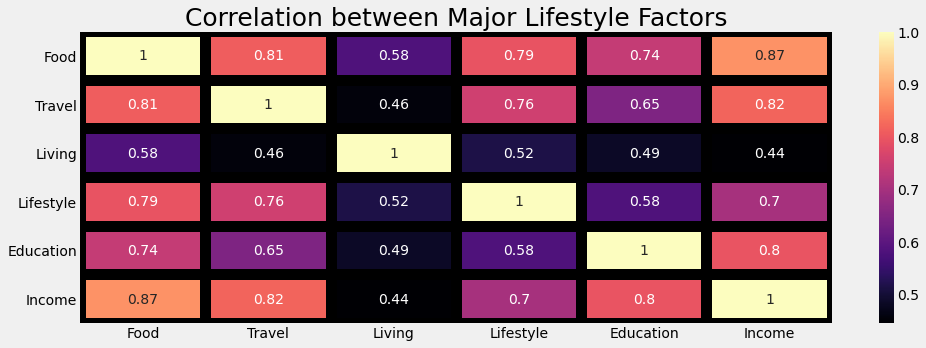

In [37]:
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight')
sns.heatmap(city[['Food','Travel','Living','Lifestyle','Education','Income']].corr(),
            cmap = 'magma',
            annot = True, linecolor = 'black', linewidths = 10)
plt.title('Correlation between Major Lifestyle Factors', fontsize = 25)
plt.show()

In [40]:
city[(city['Country'] == 'United Kingdom') | (city['Country'] == 'Australia') | 
     (city['Country'] == 'Germany') | (city['Country'] == 'China') | 
    (city['Country'] == 'Russia')][['Location','Food', 
                'Travel','Living','Lifestyle','Education',
                    'Income']].set_index('Location').sort_values(by = 'Income',
                                ascending = False).style.background_gradient(cmap = 'copper')

,Food,Travel,Living,Lifestyle,Education,Income
Location,,,,,,
"Brisbane, Australia",5,22,4644,39,4910,1517
"Sydney, Australia",5,29,5781,42,6661,1511
"Melbourne, Australia",4,21,5218,39,7062,1398
"London, United Kingdom",4,37,9069,42,11423,1380
"Adelaide, Australia",4,16,4309,34,4606,1329
"Munich, Germany",4,17,7445,44,5867,1315
"Frankfurt, Germany",3,22,6871,42,6502,1310
"Hamburg, Germany",3,21,5940,44,7085,1267
"Perth, Australia",4,20,4709,39,6358,1249


In [41]:
city['City'] = city['Location'].str.split(', ')
city['City'] = city['City'].apply(lambda x:x[0])
x = city[city['Country'] == 'India']

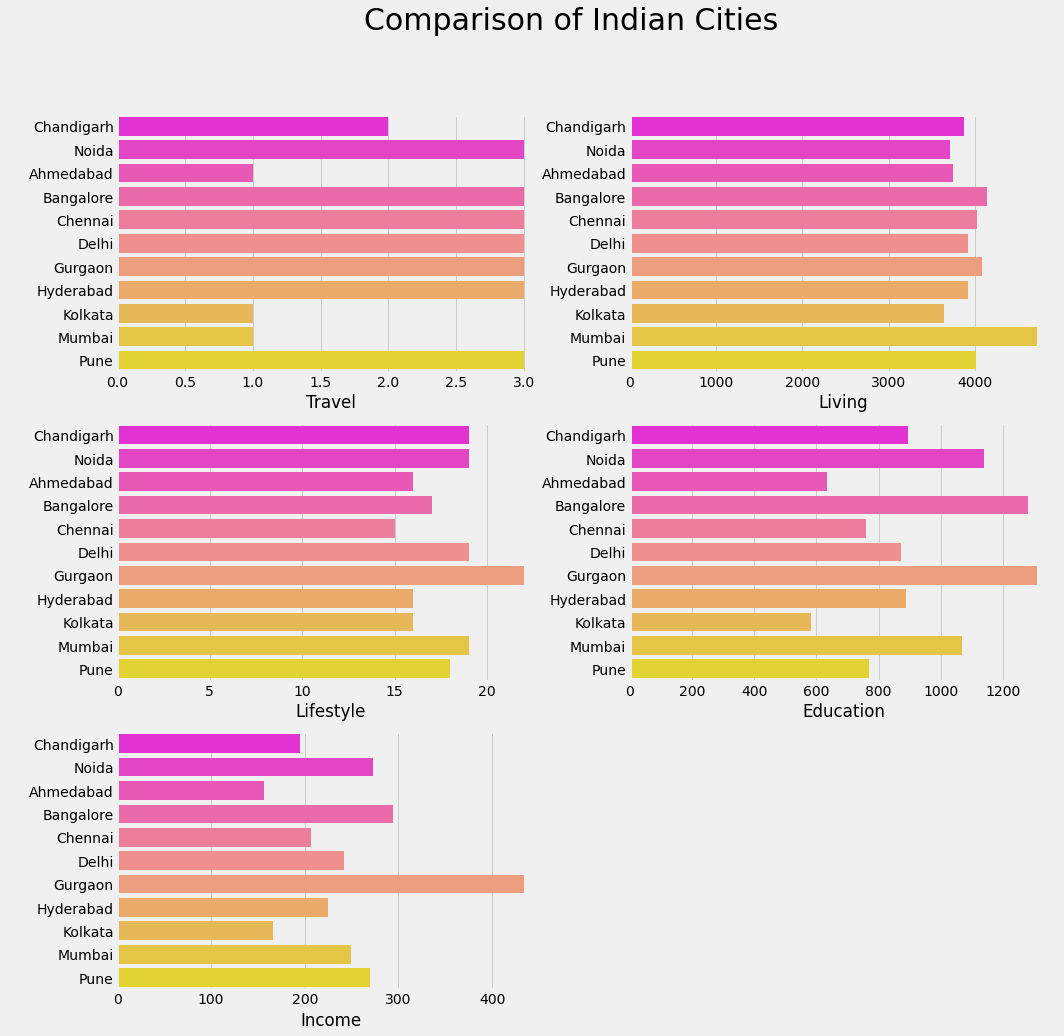

In [42]:
city['City'] = city['Location'].str.split(', ')
city['City'] = city['City'].apply(lambda x: x[0])

x = city[city['Country'] == 'India']

plt.rcParams['figure.figsize'] = (15, 15)
plt.subplot(3, 2, 1)
sns.barplot(y = x['City'], x = x['Travel'], palette = 'spring')
plt.ylabel(" ")

plt.subplot(3, 2, 2)
sns.barplot(y = x['City'], x = x['Living'], palette = 'spring')
plt.ylabel(" ")

plt.subplot(3, 2, 3)
sns.barplot(y = x['City'], x = x['Lifestyle'], palette = 'spring')
plt.ylabel(" ")

plt.subplot(3, 2, 4)
sns.barplot(y = x['City'], x = x['Education'], palette = 'spring')
plt.ylabel(" ")

plt.subplot(3, 2, 5)
sns.barplot(y = x['City'], x = x['Income'], palette = 'spring')
plt.ylabel(" ")

plt.suptitle('Comparison of Indian Cities', fontsize = 30)
plt.show()

In [43]:
x = city[['Food','Travel','Living','Lifestyle','Education','Income']]
mm = MinMaxScaler()
data = mm.fit_transform(x)
data = pd.DataFrame(data)
data.columns = x.columns
data.head()

,Food,Travel,Living,Lifestyle,Education,Income
0,0.142857,0.194444,0.139139,0.372549,0.139049,0.074890
1,0.142857,0.138889,0.161588,0.156863,0.177913,0.043424
2,0.142857,0.111111,0.155125,0.078431,0.121129,0.036816
3,0.428571,0.527778,0.252539,0.568627,0.032424,0.346759
4,0.142857,0.027778,0.082583,0.333333,0.057568,0.018250


In [45]:
data['Total Score'] = (data['Food'] + data['Travel'] + data['Living'] + 
                       data['Lifestyle'] + data['Education'] + data['Income'])/6

cities = city[['City', 'Country']]
data = pd.concat([data, cities], axis = 1)
print("Most Expensive Places in the World\n")
data[['Country','City','Total Score']].sort_values(by = 'Total Score', ascending = False).head(10)

Most Expensive Places in the World



,Country,City,Total Score
144,Switzerland,Zurich,0.790375
78,NY,New York,0.670422
100,CA,San Francisco,0.660000
39,Singapore,Singapore,0.576437
70,United Kingdom,London,0.558841
128,Iceland,Reykjavik,0.557198
102,WA,Seattle,0.539670
50,Norway,Oslo,0.534259
47,MA,Boston,0.525962
71,CA,Los Angeles,0.487471


In [46]:
print("Cheapest Places in the World\n")
data[['Country','City','Total Score']].sort_values(by = 'Total Score', ascending = True).head(10)

Cheapest Places in the World



,Country,City,Total Score
123,India,Kolkata,0.042501
106,India,Ahmedabad,0.043629
112,India,Chennai,0.056045
63,Georgia,Tbilisi,0.057976
118,India,Hyderabad,0.060394
81,India,Chandigarh,0.063713
130,India,Pune,0.069141
82,Sri Lanka,Colombo,0.069626
114,India,Delhi,0.070959
127,India,Mumbai,0.071562


#Analysing Cost of Essential Items

In [47]:
x = city[['Country','City','Milk (regular), (1 liter)',
         'Eggs (regular) (12)', 'Loaf of Fresh White Bread (500g)',
         'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)',
         'Taxi 1km (Normal Tariff)',
         'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment',
          ]]

x = x.rename(columns = {'Milk (regular), (1 liter)':'Milk','Eggs (regular) (12)':'Eggs', 
                       'Loaf of Fresh White Bread (500g)': 'Bread',
                       'Internet (60 Mbps or More, Unlimited Data, Cable/ADSL)': 'Internet',
                       'Taxi 1km (Normal Tariff)':'Taxi Travel',
                       'Basic (Electricity, Heating, Cooling, Water, Garbage) for 85m2 Apartment':'Electricity and Water'})
x.head()

,Country,City,Milk,Eggs,Bread,Internet,Taxi Travel,Electricity and Water
0,Russia,Saint Petersburg,0.98,1.18,0.71,6.96,0.26,102.17
1,Turkey,Istanbul,0.71,1.62,0.36,14.2,0.47,59.33
2,Turkey,Izmir,0.65,1.51,0.38,12.89,0.57,51.07
3,Finland,Helsinki,0.96,2.02,2.27,22.31,1,82.66
4,Moldova,Chisinau,0.68,1.11,0.33,8.58,0.18,113.46


In [48]:
x[['Milk','Bread','Eggs','Internet','Taxi Travel','Electricity and Water']].astype('float').describe()

,Milk,Bread,Eggs,Internet,Taxi Travel,Electricity and Water
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,0.998938,1.197875,1.902812,29.660875,0.922250,107.106125
std,0.391720,0.760670,0.752520,18.908249,0.709011,51.553830
min,0.390000,0.100000,0.750000,4.440000,0.140000,18.560000
25%,0.710000,0.555000,1.377500,12.832500,0.405000,63.860000
50%,0.895000,1.020000,1.850000,26.615000,0.630000,102.465000
75%,1.170000,1.690000,2.352500,43.317500,1.350000,145.707500
max,2.640000,3.330000,5.330000,93.290000,4.160000,265.520000


In [49]:
plt.rcParams['figure.figsize'] = (10, 3)
print(x[x['Milk'] > 1.17][['Country','City','Milk']].sort_values(by = 'Milk',
                                    ascending = False).head(5).set_index('Country'))

print('\n')
print(x[x['Bread'] > 1.69][['Country','City','Bread']].sort_values(by = 'Bread',
                                    ascending = False).head(5).set_index('Country'))

print('\n')
print(x[x['Eggs'] > 2.35][['Country','City','Eggs']].sort_values(by = 'Eggs',
                                    ascending = False).head(5).set_index('Country'))

print('\n')
print(x[x['Internet'] > 43.37][['Country','City','Internet']].sort_values(by = 'Internet',
                                    ascending = False).head(5).set_index('Country'))

print('\n')
print(x[x['Taxi Travel'] > 1.35][['Country','City','Taxi Travel']].sort_values(by = 'Taxi Travel',
                                    ascending = False).head(5).set_index('Country'))

print('\n')
print(x[x['Electricity and Water'] > 145.7][['Country','City',
                        'Electricity and Water']].sort_values(by = 'Electricity and Water',
                                    ascending = False).head(5).set_index('Country'))

                  City  Milk
Country                     
Taiwan          Taipei  2.64
Hong Kong    Hong Kong  2.54
China         Shanghai  2.39
Singapore    Singapore  2.04
South Korea      Seoul  1.95


                  City Bread
Country                     
NY            New York  3.33
CA           San Diego  3.27
CA       San Francisco  3.12
CA         Los Angeles  2.99
Norway            Oslo  2.92


                  City  Eggs
Country                     
Switzerland     Zurich  5.33
Iceland      Reykjavik   4.8
Norway            Oslo  3.79
France           Paris   3.4
Israel       Jerusalem  3.32


                           City Internet
Country                                 
United Arab Emirates  Abu Dhabi    93.29
United Arab Emirates      Dubai    90.42
Qatar                      Doha    78.31
AZ                      Phoenix    67.23
Costa Rica             San Jose     65.3


                             City Taxi Travel
Country                                      
Swit

#Analysing Quality of Life

In [50]:
life = pd.read_csv('movehubqualityoflife.csv')
life.head()

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating
0,Caracas,65.18,11.25,44.44,83.45,8.61,85.70
1,Johannesburg,84.08,53.99,59.98,47.39,51.26,83.93
2,Fortaleza,80.17,52.28,45.46,66.32,36.68,78.65
3,Saint Louis,85.25,80.40,77.29,31.33,87.51,78.13
4,Mexico City,75.07,24.28,61.76,18.95,27.91,77.86


In [51]:
life.describe()

,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,79.676713,46.477176,66.442824,45.240370,59.994537,41.338611
std,6.501011,20.614519,14.416412,25.369741,22.019376,16.416409
min,59.880000,6.380000,20.830000,0.000000,5.290000,9.110000
25%,75.070000,28.815000,59.420000,24.410000,42.752500,29.375000
50%,81.060000,49.220000,67.685000,37.210000,65.150000,41.140000
75%,84.020000,61.607500,77.207500,67.675000,78.617500,51.327500
max,100.000000,91.850000,95.960000,92.420000,97.910000,85.700000


In [52]:
print('Cities having Best Quality of life')
display(life[['City','Quality of Life']].sort_values(by = 'Quality of Life',
                            ascending = False).head(10).set_index('City').style.background_gradient(cmap = 'Reds'))

print('Cities having Worst Quality of life')
display(life[['City','Quality of Life']].sort_values(by = 'Quality of Life',
                            ascending = True).head(10).set_index('City').style.background_gradient(cmap = 'Reds'))

Cities having Best Quality of life


,Quality of Life
City,
Zurich,97.910000
Canberra,93.050000
Adelaide,91.540000
Berlin,91.170000
Aachen,90.520000
Stuttgart,90.400000
Dresden,90.210000
Munich,90.080000
Edmonton,89.580000


Cities having Worst Quality of life


,Quality of Life
City,
Hanoi,5.290000
Caracas,8.610000
Manila,13.140000
Dhaka,13.480000
Tehran,14.330000
Nairobi,14.360000
Jakarta,15.660000
Baku,17.200000
Cairo,17.250000


In [53]:
print('Cities having Best Health care Facility')
display(life[['City','Health Care']].sort_values(by = 'Health Care',
                            ascending = False).head(10).set_index('City').style.background_gradient(cmap = 'Greens'))

print('Cities having Worst Health care Facility')
display(life[['City', 'Health Care']].sort_values(by = 'Health Care',
                            ascending = True).head(10).set_index('City').style.background_gradient(cmap = 'Greens'))

Cities having Best Health care Facility


,Health Care
City,
Bangkok,95.960000
Canberra,91.900000
Pattaya,91.460000
Glasgow,90.550000
Taipei,88.890000
Brisbane,88.890000
Bristol,88.890000
Lyon,88.650000
Munich,88.430000


Cities having Worst Health care Facility


,Health Care
City,
Dhaka,20.830000
Hanoi,20.830000
Gaborone,27.780000
Baku,28.700000
Kolkata,31.290000
Indore,31.340000
Quito,32.410000
Belfast,33.330000
Kharkiv,35.060000


In [54]:
print('Cities having Highest Crime Rate')
display(life[['City','Crime Rating']].sort_values(by = 'Crime Rating',
                            ascending = False).head(10).set_index('City').style.background_gradient(cmap = 'bone'))

print('Cities having Worst Health care Facility')
display(life[['City', 'Crime Rating']].sort_values(by = 'Crime Rating',
                            ascending = True).head(10).set_index('City').style.background_gradient(cmap = 'bone'))

Cities having Highest Crime Rate


,Crime Rating
City,
Caracas,85.700000
Johannesburg,83.930000
Fortaleza,78.650000
Saint Louis,78.130000
Mexico City,77.860000
Detroit,76.690000
Porto Alegre,76.460000
Noida,75.000000
Karachi,74.360000


Cities having Worst Health care Facility


,Crime Rating
City,
Malaga,9.110000
Marbella,9.110000
Abu Dhabi,10.860000
Tokyo,13.910000
Munich,15.340000
Aachen,15.340000
Dusseldorf,15.340000
Dresden,15.340000
Zurich,15.350000


##Recomending Better Cities to Live

In [55]:
def recommend_better_cities(citi, factor = 'Lifestyle'):
    x = city[['City','Food','Education','Lifestyle','Travel', 'Income']]
    food = x[x['City'] == citi]['Food']
    edu = x[x['City'] == citi]['Education']
    life = x[x['City'] == citi]['Lifestyle']
    travel = x[x['City'] == citi]['Travel']
    income = x[x['City'] == citi]['Income']
    best_cities = x[(x['Food'] <= food.values[0]) & (x['Education'] <= edu.values[0]) & 
                   (x['Lifestyle'] <= life.values[0]) & (x['Travel'] <= travel.values[0]) &
                   (x['Income'] > income.values[0])]
    best = best_cities.sort_values(by = factor, ascending = False).head(10)
    return best['City'].reset_index(drop = True)
recommend_better_cities('Sydney')

0     Brisbane
1    Las Vegas
Name: City, dtype: object

In [57]:
recommend_better_cities('Ahmedabad')

0    Kolkata
Name: City, dtype: object